# Determining optimal number of topics using Coherence Score

Determining the optimal number of topics (num_topics) in LDA topic modeling is crucial for extracting meaningful insights. We can use coherence score to find the best number of topics. The coherence score measures the quality of topics by evaluating the semantic similarity of the top words in each topic. The higher the coherence score, the better the topics.

Note:
In topic modeling using Latent Dirichlet Allocation (LDA), the coherence score is a metric used to evaluate how semantically similar the words within a topic are to each other, essentially measuring how interpretable and meaningful a given topic is to humans; a higher coherence score indicates that the words within a topic are closely related and make sense together, while a lower score suggests a less coherent, unclear topic. 

Num Topics: 2, Coherence Score: 0.4440
Num Topics: 4, Coherence Score: 0.4734
Num Topics: 6, Coherence Score: 0.5585
Num Topics: 8, Coherence Score: 0.5149
Num Topics: 10, Coherence Score: 0.5502
Num Topics: 12, Coherence Score: 0.5745
Num Topics: 14, Coherence Score: 0.5697


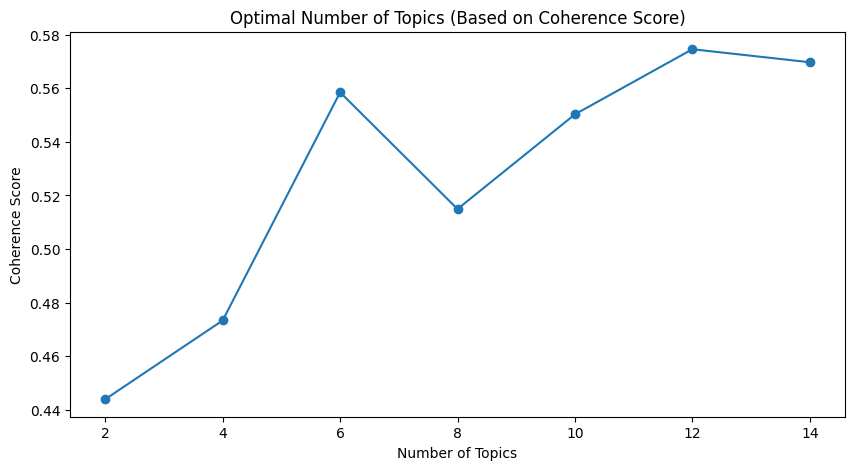

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  # Replace with actual file path

# Step 2: Ensure `content_words` is a list of tokenized words
df['content_words'] = df['content_words'].apply(eval)  # Convert string to list if needed

# Step 3: Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['content_words'])
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=10000)  # Reduce noise
corpus = [dictionary.doc2bow(text) for text in df['content_words']]

# Step 4: Define a range of topic numbers to test
topic_range = range(2, 15, 2)  # Test even numbers between 2 and 14
coherence_scores = []

# Step 5: Train LDA models with different `num_topics` and calculate coherence
for num_topics in topic_range:
    lda_model = gensim.models.LdaMulticore(
        corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=4, random_state=42
    )
    
    coherence_model = CoherenceModel(model=lda_model, texts=df['content_words'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Step 6: Plot Coherence Score vs Number of Topics
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics (Based on Coherence Score)")
plt.show()

# WordCloud and Bar Chart as the Visualization of the Topic Modelling Result

LDA Coherence Score: 0.5833
Topic 0: 0.021*"case" + 0.021*"state" + 0.016*"law" + 0.015*"court" + 0.011*"federal" + 0.007*"charge" + 0.007*"trial" + 0.007*"decision" + 0.007*"act" + 0.007*"legal"

Topic 1: 0.012*"service" + 0.009*"health" + 0.007*"program" + 0.007*"site" + 0.007*"offer" + 0.007*"online" + 0.006*"system" + 0.006*"information" + 0.006*"used" + 0.006*"help"

Topic 2: 0.016*"show" + 0.010*"video" + 0.009*"news" + 0.008*"game" + 0.007*"book" + 0.007*"post" + 0.007*"play" + 0.007*"story" + 0.006*"read" + 0.005*"social_medium"

Topic 3: 0.014*"city" + 0.009*"police" + 0.009*"home" + 0.006*"area" + 0.006*"hour" + 0.006*"killed" + 0.006*"four" + 0.006*"later" + 0.005*"last" + 0.005*"fire"

Topic 4: 0.032*"policy" + 0.025*"government" + 0.017*"change" + 0.016*"however" + 0.011*"plan" + 0.010*"per_cent" + 0.009*"report" + 0.007*"uk" + 0.007*"figure" + 0.006*"economic"

Topic 5: 0.021*"million" + 0.015*"price" + 0.014*"high" + 0.012*"cost" + 0.011*"rate" + 0.011*"number" + 0.009*"

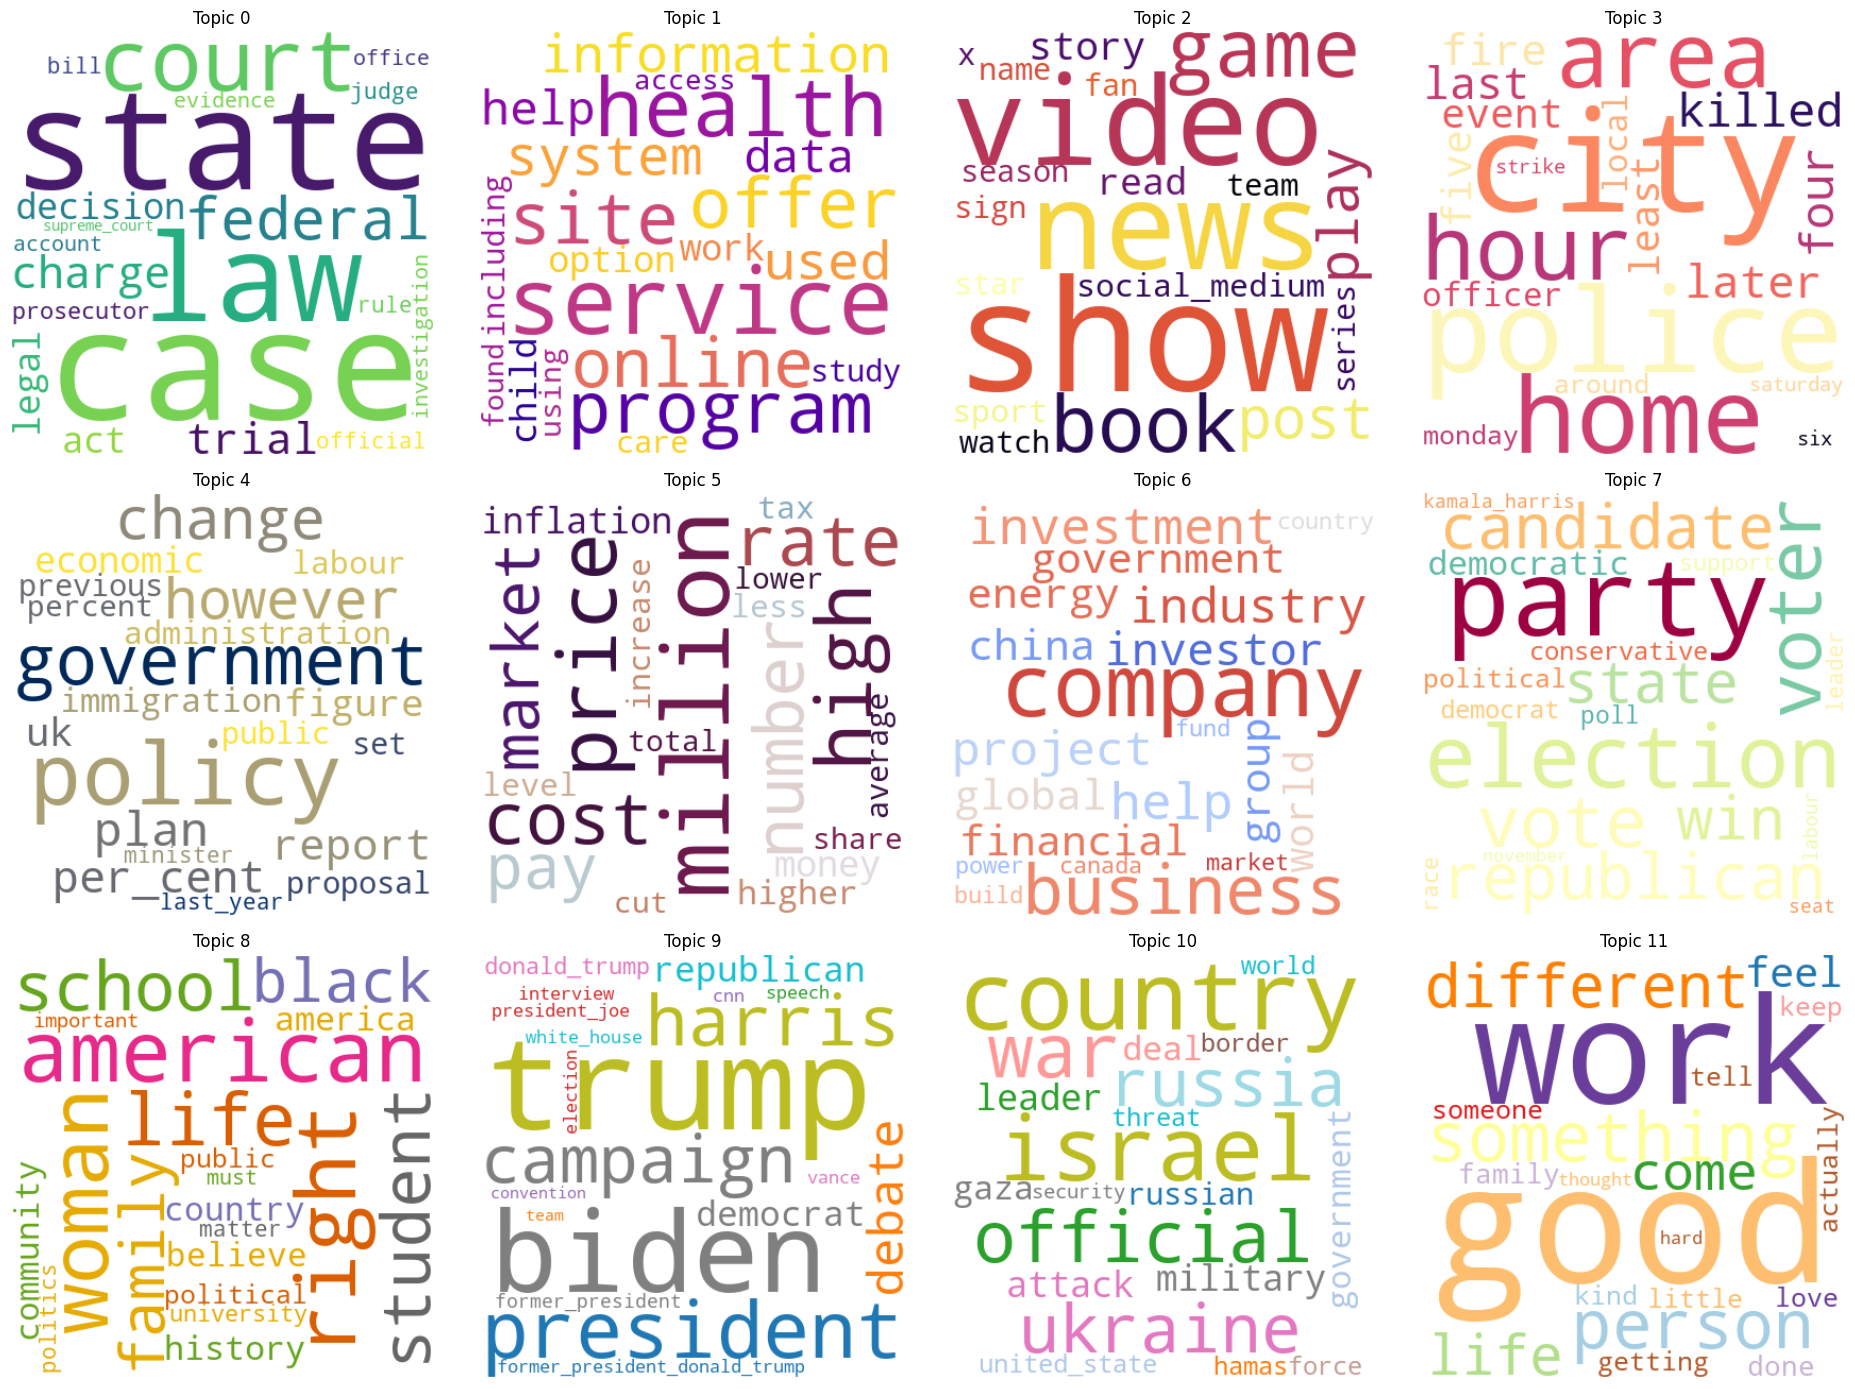

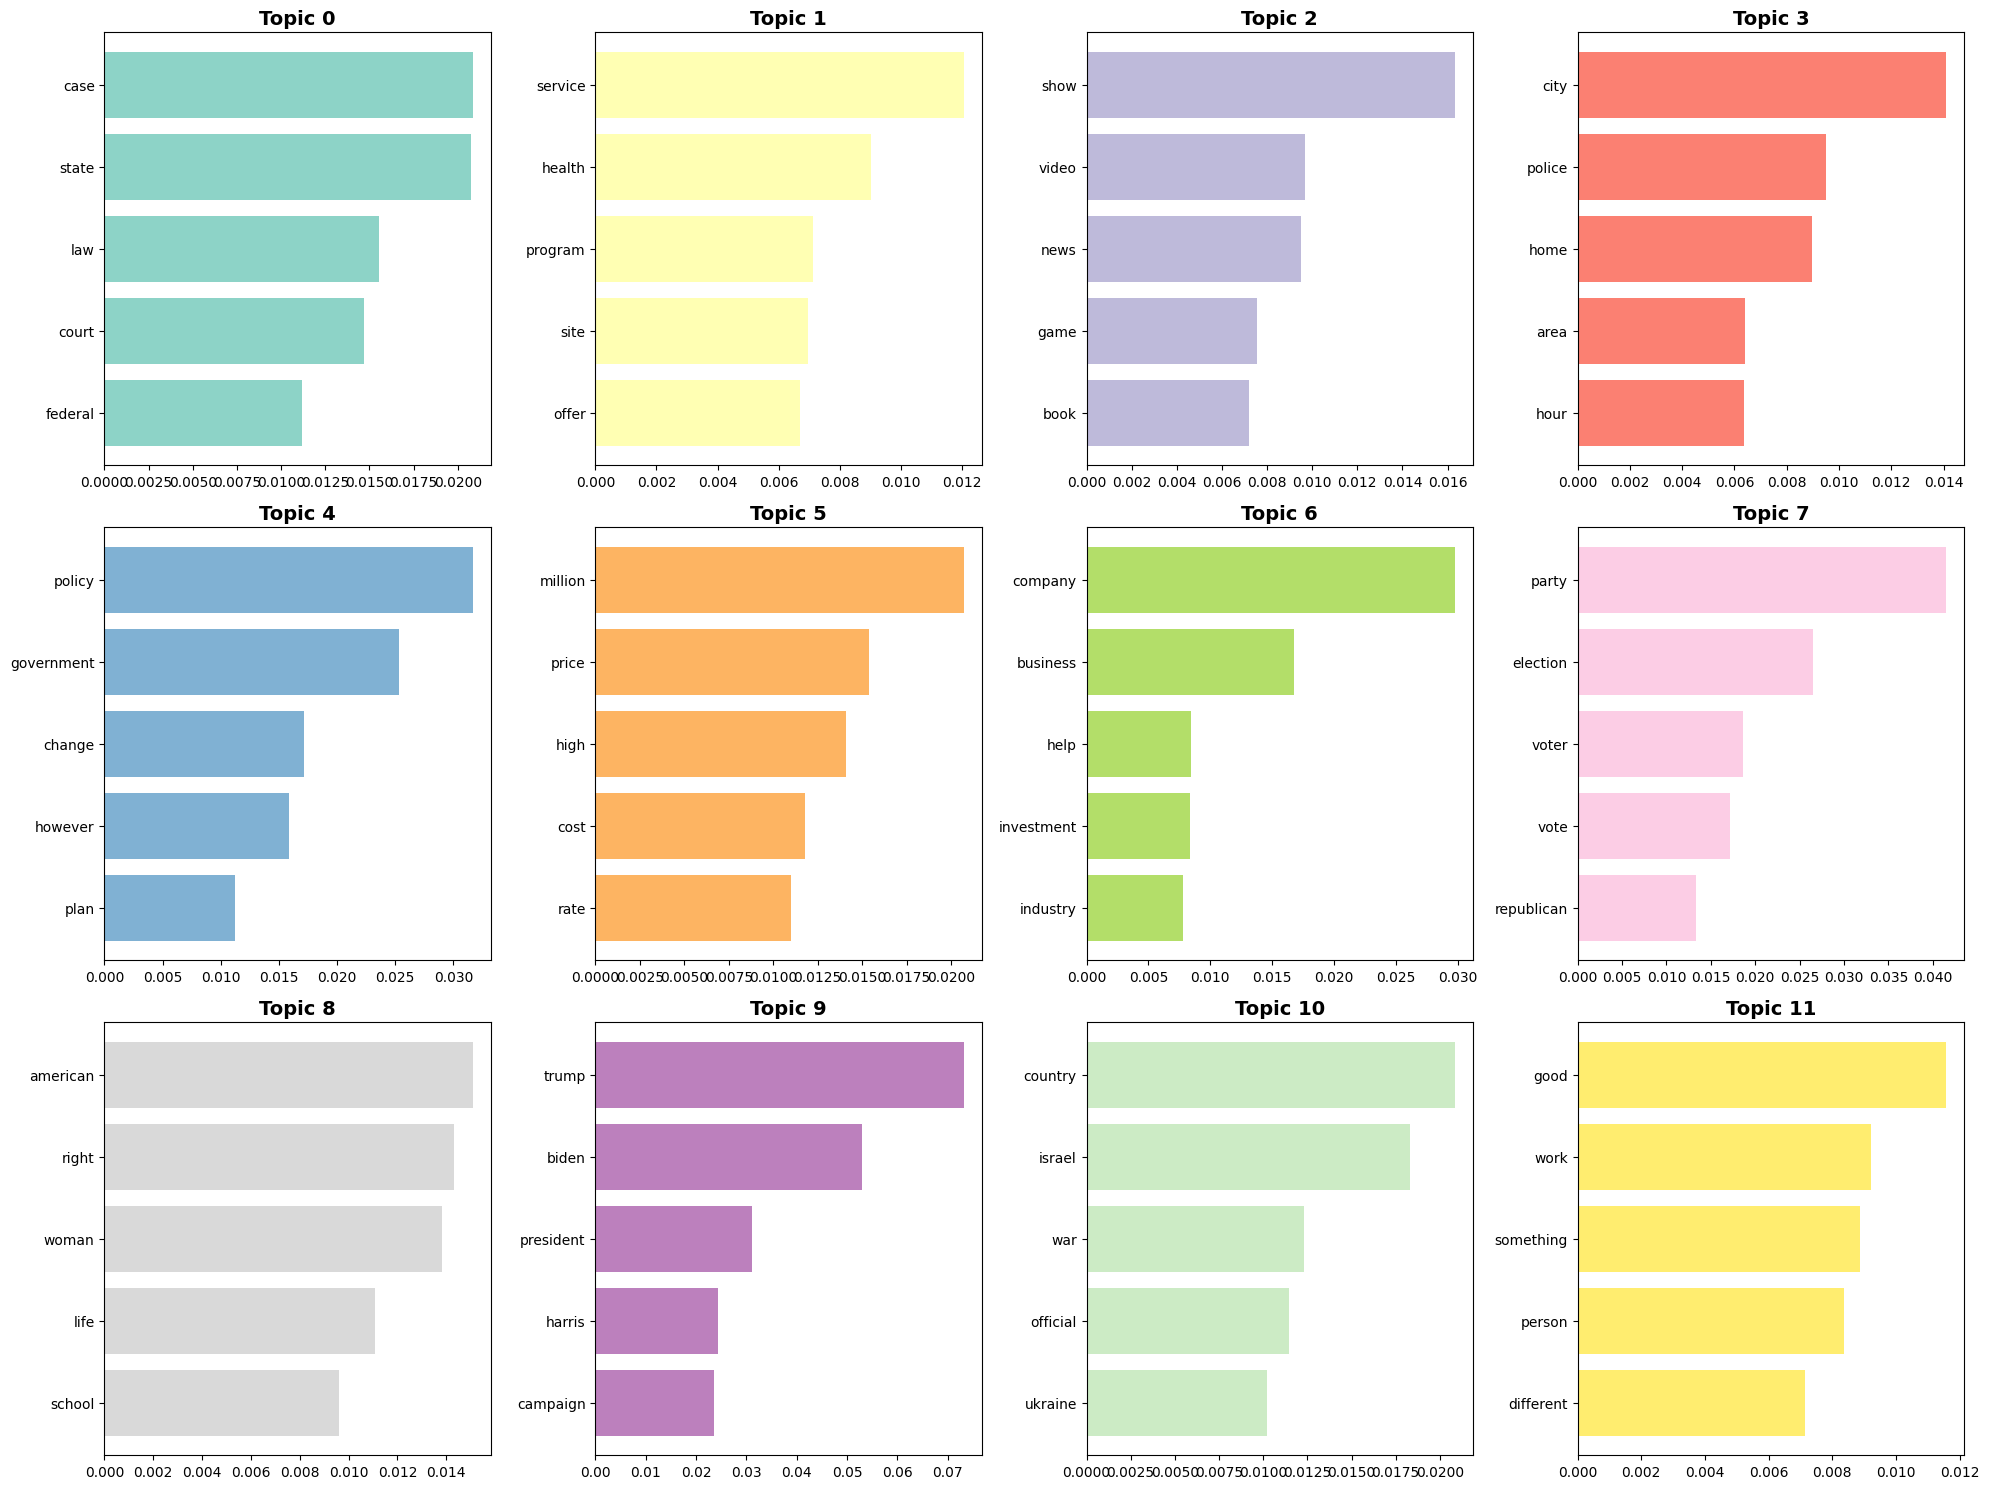

In [2]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import seaborn as sns

# Load dataset (update with your actual file path)
df = pd.read_csv("../datasets/news_dataset_content_cleaned.csv")  # Replace with actual file path

# Convert content_words column (assumed to be list-like) into a list of tokenized words
df['content_words'] = df['content_words'].apply(eval)  # Ensure the column is in list format

# 1. Detect Bigrams and Trigrams with Higher Threshold
bigram = Phrases(df['content_words'], min_count=10, threshold=30)  # Increased min_count and threshold
trigram = Phrases(bigram[df['content_words']], min_count=10, threshold=30)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams
df['content_words'] = df['content_words'].apply(lambda x: trigram_mod[bigram_mod[x]])

# 2. Remove Low-Information Words (Expanded Stopwords List)
custom_stopwords = set([
    "said", "one", "new", "people", "like", "time", "year", "just", "know", "think", "make", "get", "also",
    "many", "day", "week", "month", "even", "still", "back", "see", "way", "want", "need", "thing", "go",
    "use", "give", "first", "two", "three", "take", "since", "well", "much", "could", "should", "would", 
    "question", "statement", "really", "going", "u", "best", "lot", "far", "added", "got", "may",
    "according", "might", "whether", "say", "look", "always", "let", "yet", "asked", "across", "never",
    "di", "mean"
])
df['content_words'] = df['content_words'].apply(lambda x: [word for word in x if word not in custom_stopwords])

# 3. Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['content_words'])

# 4. Filter out extreme tokens (Higher no_below to remove rare words)
dictionary.filter_extremes(no_below=20, no_above=0.3, keep_n=10000)  # Increased no_below from 10 to 20

# 5. Convert to Bag-of-Words format
corpus = [dictionary.doc2bow(text) for text in df['content_words']]

# 6. Train LDA Model Using MULTICORE Processing
num_topics = 12
lda_model = LdaMulticore(
    corpus=corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=10,  # Increased passes for better convergence
    workers=multiprocessing.cpu_count(),  # Use all available CPU cores
    random_state=42
)

# 7. Compute LDA Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=df['content_words'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"LDA Coherence Score: {coherence_score:.4f}")

# 8. Print the top words in each topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")

# 9. Visualize topics using WordClouds (4 topics per row, 3 rows) with distinct readable colors
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 14))
axes = axes.flatten()
wordcloud_colors = ["viridis", "plasma", "inferno", "magma", "cividis", "twilight", "coolwarm", "Spectral", "Dark2", "tab10", "tab20", "Paired"]  # Distinct colors avoiding very light ones

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 20))
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=wordcloud_colors[i]).generate_from_frequencies(topic_words)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i}")

plt.tight_layout()
plt.show()

# 10. Save the model and dictionary
lda_model.save("lda_model.model")
dictionary.save("lda_dictionary.dict")

# 11. Generate Bar Chart for Top 5 Words in Each Topic with Fully Distinct Colors
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()
distinct_colors = sns.color_palette("Set3", num_topics)  # Using Set3 for better distinct colors

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, 5))  # Get top 5 words
    words = list(topic_words.keys())
    values = list(topic_words.values())
    
    axes[i].barh(words, values, color=distinct_colors[i])  # Assign distinct colors
    axes[i].invert_yaxis()
    axes[i].set_title(f"Topic {i}", fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.show()

# Top 10 News Sources based on Topic Probability Distribution (Analyzing which outlets contribute most to topics)

This code analyzes how different news outlets cover various topics using a trained LDA model. It first extracts topic probabilities for each document and aggregates them by news source. The top 10 news sources are selected based on their total topic probability, ensuring that the most influential outlets are analyzed. The topic distributions are then normalized for fair comparison. The results are visualized using:

Stacked Bar Chart – Shows the proportion of topics across the top 10 news sources.
Heatmap – Highlights topic intensity for each news outlet, with a light-to-dark red gradient indicating lower to higher topic presence.
These visualizations help identify how different media sources emphasize various topics.

<Figure size 1400x800 with 0 Axes>

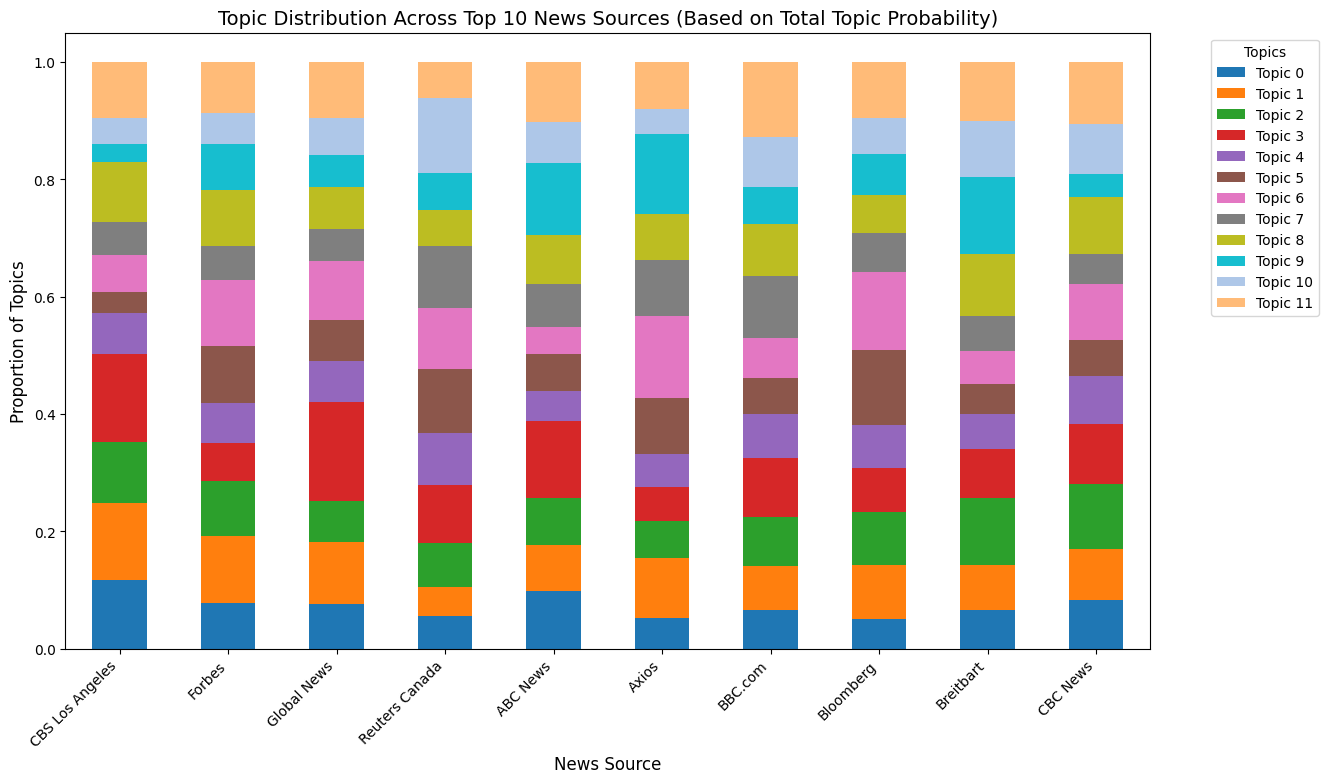

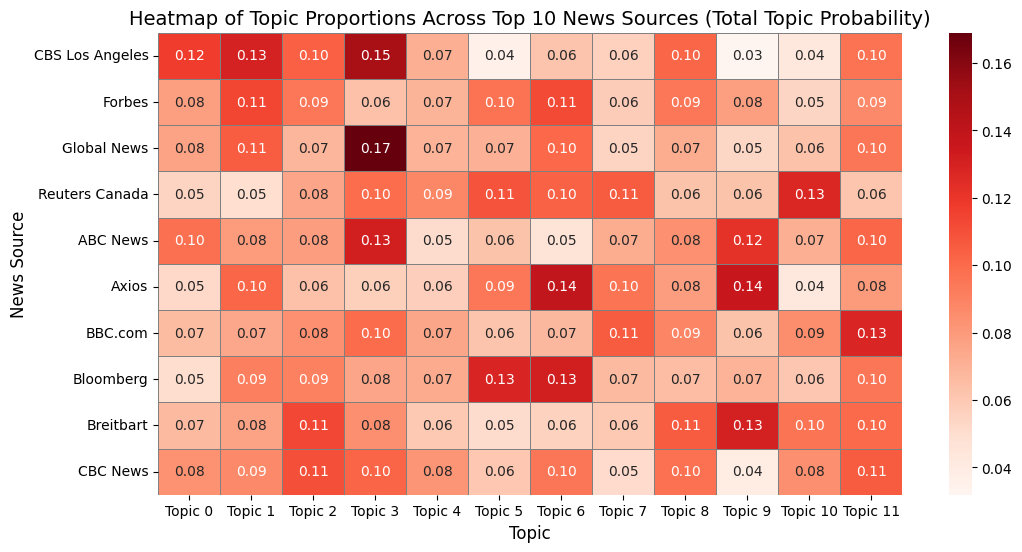

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get topic distribution per document
def get_topic_distribution(lda_model, corpus):
    topic_distributions = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        topic_vector = [prob for _, prob in topic_probs]
        topic_distributions.append(topic_vector)
    return np.array(topic_distributions)

# Compute topic distribution for each document
topic_distributions = get_topic_distribution(lda_model, corpus)

# Convert to DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(num_topics)])
topic_df["outlet"] = df["outlet"]  # Add news source information

# Aggregate topic probabilities per outlet
outlet_topic_distribution = topic_df.groupby("outlet").mean()

# Select top 10 news sources based on total topic probability
top_outlets = outlet_topic_distribution.sum(axis=1).nlargest(10).index
filtered_distribution = outlet_topic_distribution.loc[top_outlets]

# Normalize topic proportions (percentage-based)
filtered_distribution = filtered_distribution.div(filtered_distribution.sum(axis=1), axis=0)

# Option 1: Improved Stacked Bar Chart with Better Colors
plt.figure(figsize=(14, 8))
color_palette = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78"
]  # Manually selected visually distinct and aesthetically pleasing colors

ax = filtered_distribution.plot(kind="bar", stacked=True, figsize=(14, 8), color=color_palette)

plt.title("Topic Distribution Across Top 10 News Sources (Based on Total Topic Probability)", fontsize=14)
plt.xlabel("News Source", fontsize=12)
plt.ylabel("Proportion of Topics", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Option 2: Improved Heatmap with "Reds" Colormap
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_distribution, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5, linecolor="gray")

plt.title("Heatmap of Topic Proportions Across Top 10 News Sources (Total Topic Probability)", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("News Source", fontsize=12)
plt.show()
